In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

IMAGE_SIZE = (128, 128)
source_dir = 'img/data/'

In [9]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[1], width=IMAGE_SIZE[0]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)
model.load_state_dict(torch.load('model/checkpointsv6/model_2.pth'))

def use_model(path):
    imgs = []
    imgs_prep = []
    masks_res = []
    for p in path:
        im = cv2.imread(p)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        imgs.append(im.copy())
        
        im = transform(image=im)['image']
        imgs_prep.append(im)

    imgs_prep = torch.stack(imgs_prep)
    masks = torch.squeeze(model(imgs_prep), dim=1)
    masks = torch.sigmoid(masks) > 0.5

    for i in range(len(imgs)):
        m = cv2.resize(np.where(masks[i], 255, 0).astype(np.uint8), imgs[i].shape[-2::-1])
        masks_res.append(m.astype(np.uint8))
    
    return imgs, masks_res

In [3]:
# import numpy as np
# import cv2

# def genTemplate(img): 
#     global H_templ_ratio
#     # we get the image's width and height
#     h, w = img.shape[:2]
#     # we compute the template's bounds
#     x1 = int(float(w)*(1-H_templ_ratio))
#     y1 = 0
#     x2 = w
#     y2 = h
#     return(img[y1:y2,x1:x2]) # and crop the input image

# def mat2Edges(img): # applies a Canny filter to get the edges
#     edged = cv2.Canny(img, 100, 200)
#     return(edged)

# def addBlackMargins(img, top, bottom, left, right): # top, bottom, left, right: margins width in pixels
#     h, w = img.shape[:2]
#     result = np.zeros((h+top+bottom, w+left+right, 3), np.uint8)
#     result[top:top+h,left:left+w] = img
#     return(result)

# # return the y_offset of the first image to stitch and the final image size needed
# def calcFinalImgSize(imgs, loc):
#     global V_templ_ratio, H_templ_ratio
#     y_offset = 0
#     max_margin_top = 0; max_margin_bottom = 0 # maximum margins that will be needed above and bellow the first image in order to stitch all the images into one mat
#     current_margin_top = 0; current_margin_bottom = 0

#     h_init, w_init = imgs[0].shape[:2]
#     w_final = w_init
    
#     for i in range(0,len(loc)):
#         h, w = imgs[i].shape[:2]
#         h2, w2 = imgs[i+1].shape[:2]
#         # we compute the max top/bottom margins that will be needed (relatively to the first input image) in order to stitch all the images
#         current_margin_top += loc[i][1] # here, we assume that the template top-left corner Y-coordinate is 0 (relatively to its original image)
#         current_margin_bottom += (h2 - loc[i][1]) - h
#         if(current_margin_top > max_margin_top): max_margin_top = current_margin_top
#         if(current_margin_bottom > max_margin_bottom): max_margin_bottom = current_margin_bottom
#         # we compute the width needed for the final result
#         x_templ = int(float(w)*H_templ_ratio) # x-coordinate of the template relatively to its original image
#         w_final += (w2 - x_templ - loc[i][0]) # width needed to stitch all the images into one mat

#     h_final = h_init + max_margin_top + max_margin_bottom
#     return (max_margin_top, h_final, w_final)

# # match each input image with its following image (1->2, 2->3) 
# def matchImages(imgs, templates_loc):
#     for i in range(0,len(imgs)-1):
#         template = genTemplate(imgs[i])
#         template = mat2Edges(template)
#         h_templ, w_templ = template.shape[:2]
#         # Apply template Matching
#         margin_top = margin_bottom = h_templ; margin_left = margin_right = 0
#         img = addBlackMargins(imgs[i+1],margin_top, margin_bottom, margin_left, margin_right) # we need to enlarge the input image prior to call matchTemplate (template needs to be strictly smaller than the input image)
#         img = mat2Edges(img)
#         res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF) # matching function
#         _, _, _, templ_pos = cv2.minMaxLoc(res) # minMaxLoc gets the best match position
#         # as we added margins to the input image we need to subtract the margins width to get the template position relatively to the initial input image (without the black margins)
#         rectified_templ_pos = (templ_pos[0]-margin_left, templ_pos[1]-margin_top) 
#         templates_loc.append(rectified_templ_pos)
#         print("max_loc", rectified_templ_pos)

# def stitchImages(imgs, templates_loc):
#     y_offset, h_final, w_final = calcFinalImgSize(imgs, templates_loc) # we calculate the "surface" needed to stitch all the images into one mat (and y_offset, the Y offset of the first image to be stitched) 
#     result = np.zeros((h_final, w_final, 3), np.uint8)

#     #initial stitch
#     h_init, w_init = imgs[0].shape[:2]
#     result[y_offset:y_offset+h_init, 0:w_init] = imgs[0]
#     origin = (y_offset, 0) # top-left corner of the last stitched image (y,x)
#     # stitching loop
#     for j in range(0,len(templates_loc)):
#         h, w = imgs[j].shape[:2]
#         h2, w2 = imgs[j+1].shape[:2]
#         # we compute the coordinates where to stitch imgs[j+1]
#         y1 = origin[0] - templates_loc[j][1]
#         y2 = origin[0] - templates_loc[j][1] + h2
#         x_templ = int(float(w)*(1-H_templ_ratio)) # x-coordinate of the template relatively to its original image's right side
#         x1 = origin[1] + x_templ - templates_loc[j][0]
#         x2 = origin[1] + x_templ - templates_loc[j][0] + w2
#         result[y1:y2, x1:x2] = imgs[j+1] # we copy the input image into the result mat
#         origin = (y1,x1) # we update the origin point with the last stitched image

#     return(result)




In [10]:
import numpy as np
import cv2

H_templ_ratio = 0.2
V_templ_ratio = 1.0

# def genTemplate(img): 
#     global H_templ_ratio
#     h, w = img.shape[:2]
#     x1 = int(float(w) * (1 - H_templ_ratio))
#     return img[:, x1:x2]

def genTemplate(img): 
    global H_templ_ratio
    h, w = img.shape[:2]
    x1 = int(float(w) * (1 - H_templ_ratio))
    x2 = w
    return img[:, x1:x2]

def mat2Edges(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img, 100, 200)
    return edged

def addBlackMargins(img, top, bottom, left, right):
    h, w = img.shape[:2]
    if len(img.shape) == 3:
        result = np.zeros((h + top + bottom, w + left + right, 3), dtype=np.uint8)
    else:
        result = np.zeros((h + top + bottom, w + left + right), dtype=np.uint8)
    result[top:top + h, left:left + w] = img
    return result

def calcFinalImgSize(imgs, loc):
    global H_templ_ratio
    y_offset = 0
    max_margin_top = 0
    max_margin_bottom = 0
    current_margin_top = 0
    current_margin_bottom = 0

    h_init, w_init = imgs[0].shape[:2]
    w_final = w_init

    for i in range(len(loc)):
        h, w = imgs[i].shape[:2]
        h2, w2 = imgs[i + 1].shape[:2]

        current_margin_top += loc[i][1]
        current_margin_bottom += (h2 - loc[i][1]) - h

        if current_margin_top > max_margin_top:
            max_margin_top = current_margin_top
        if current_margin_bottom > max_margin_bottom:
            max_margin_bottom = current_margin_bottom

        x_templ = int(float(w) * H_templ_ratio)
        w_final += (w2 - x_templ - loc[i][0])

    h_final = h_init + max_margin_top + max_margin_bottom
    return max_margin_top, h_final, w_final

def matchImages(imgs, templates_loc):
    for i in range(len(imgs) - 1):
        template = genTemplate(imgs[i])
        template = mat2Edges(template)
        h_templ, w_templ = template.shape[:2]

        margin_top = margin_bottom = h_templ
        margin_left = margin_right = 0

        img_padded = addBlackMargins(imgs[i + 1], margin_top, margin_bottom, margin_left, margin_right)
        img_padded = mat2Edges(img_padded)

        res = cv2.matchTemplate(img_padded, template, cv2.TM_CCOEFF)
        _, _, _, templ_pos = cv2.minMaxLoc(res)
        rectified_templ_pos = (templ_pos[0] - margin_left, templ_pos[1] - margin_top)
        templates_loc.append(rectified_templ_pos)
        print("max_loc", rectified_templ_pos)

def stitchImagesWithMasks(imgs, floor_masks, templates_loc):
    y_offset, h_final, w_final = calcFinalImgSize(imgs, templates_loc)

    is_mask_color = len(floor_masks[0].shape) == 3
    mask_channels = 3 if is_mask_color else 1

    stitched_img = np.zeros((h_final, w_final, 3), dtype=np.uint8)
    if mask_channels == 3:
        stitched_mask = np.zeros((h_final, w_final, 3), dtype=np.uint8)
    else:
        stitched_mask = np.zeros((h_final, w_final), dtype=np.uint8)

    h0, w0 = imgs[0].shape[:2]
    stitched_img[y_offset:y_offset + h0, 0:w0] = imgs[0]
    stitched_mask[y_offset:y_offset + h0, 0:w0] = floor_masks[0]

    origin = (y_offset, 0) 

    for j in range(len(templates_loc)):
        h, w = imgs[j].shape[:2]
        h2, w2 = imgs[j + 1].shape[:2]

        y1 = origin[0] - templates_loc[j][1]
        y2 = y1 + h2
        x_templ = int(float(w) * (1 - H_templ_ratio))
        x1 = origin[1] + x_templ - templates_loc[j][0]
        x2 = x1 + w2

        stitched_img[y1:y2, x1:x2] = imgs[j + 1]
        stitched_mask[y1:y2, x1:x2] = floor_masks[j + 1]
        origin = (y1, x1)

    return stitched_img, stitched_mask

In [11]:
paths = [f'{source_dir}/{p}.jpg' for p in range(1, 7)]

In [13]:
imgs, masks = use_model(paths)

templates_loc = []

matchImages(imgs, templates_loc)

result = stitchImagesWithMasks(imgs, masks, templates_loc)

max_loc (933, -110)
max_loc (913, -87)
max_loc (942, -124)
max_loc (984, -54)
max_loc (938, -48)


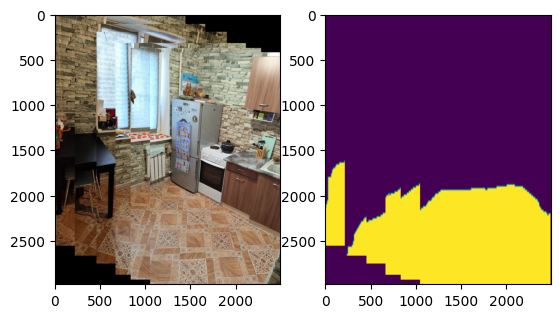

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(result[0])
ax[1].imshow(result[1])